In [28]:
from coffea.util import load
import numpy as np
import pandas as pd
import glob, os, json, argparse
years = ['2016preVFP', '2016postVFP', '2018','2017']
var_dict = [{}, {}, {}]
for year in years:
  print(f'Processing {year}')
  result = load(f"../results/{year}/makeDF/output_WJet2.coffea")
  if isinstance(result,tuple):
      result = result[0]
  for varName in result:
    for i in range(2,3):
      if f'{i}jets' in varName:
        if varName.replace(f'_{i}jets','') in var_dict[i]:
          var_dict[i][varName.replace(f'_{i}jets','')] = np.append(var_dict[i][varName.replace(f'_{i}jets','')],result[varName].value)
        else:
          var_dict[i][varName.replace(f'_{i}jets','')] = result[varName].value
df = pd.DataFrame(var_dict[i])

Processing 2016preVFP
Processing 2016postVFP
Processing 2018
Processing 2017


In [29]:
data_clean = df[df.e_m_Mass.gt(110) & df.e_m_Mass.lt(160))

In [54]:
feature_names = ['mpt', 'njets', 'met', 'DeltaEta_e_m', 'empt', 'DeltaPhi_em_met', 'j1pt', 'j2pt', 'DeltaEta_j1_em', 'j1Eta', 'DeltaEta_j1_j2', 'j1_j2_mass', 'Ht_had', 'Rpt', 'pt_cen_Deltapt']

In [55]:
feature_names_tex = ['$p_{T}^{\mu}$', '#Jets', '$E^{miss}_{T}$', '$\Delta \eta[e, \mu]$', '$p_{T}^{e\mu}$', '$\Delta \phi[e\mu, MET]$', '$p_{T}^{j_{1}}$', '$p_{T}^{j_{2}}$', '$\Delta \eta[j_{1}, e\mu]$', '$\eta^{j_{1}}$', '$\Delta \eta[j_{1}, j_{2}]$', '$m_{j_{1}j_{2}}$ [GeV]', '$H_{T}$', '$R_{p_{T}}$', '$p_{T}$-centrality']
feature_names_tex_dict = {feature_name:feature_name_tex for feature_name, feature_name_tex in zip(feature_names, feature_names_tex)}

In [32]:
print(len(feature_names),len(feature_names_tex))

14 14


In [33]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

print(corr(data_bkg['empt'], data_bkg['e_m_Mass'], data_bkg['weight']))

0.04942427343568633


In [44]:
features_map = {
    "mva": ['BDT Discriminator', 30, 0, 1],
    "e_m_Mass": ['$m_{e\mu}$ [GeV]', 50, 110, 160],
    "met": ['$E^{miss}_{T}$ [GeV]', 30, 0, 200],
    "eEta": ['$\eta^{e}$', 30, -2.5, 2.5],
    "mEta": ['$\eta^{\mu}$', 30, -2.5, 2.5],
    "mpt": ['$p_{T}^{\mu}$', 30, 26, 200], 
    "ept": ['$p_{T}^{e}$', 30, 24, 200], 
    "mpt_Per_e_m_Mass": ['$p_{T}^{\mu}/m_{e\mu}$', 30, 0.15, 1], 
    "ept_Per_e_m_Mass": ['$p_{T}^{e}/m_{e\mu}$', 30, 0.15, 1], 
    "empt": ['$p_{T}^{e\mu}$ [GeV]', 30, 0, 200],
    "emEta": ['$\eta^{e\mu}$', 30, -6, 6], 
    "DeltaEta_e_m": ['$\Delta \eta[e, \mu]$', 30, 0, 3.5], 
    "DeltaPhi_e_m": ['$\Delta \phi[e, \mu]$', 30, 0, 3.2], 
    "DeltaPhi_em_met": ['$\Delta \phi[e\mu, MET]$', 30, 0, 3.2], 
    "DeltaR_e_m": ['$\Delta R[e, \mu]$', 30, 0, 4.5], 
    "e_met_mT": ['$m_{T}[e, MET]$', 30, 0, 250], 
    "m_met_mT": ['$m_{T}[\mu, MET]$', 30, 0, 250], 
    "e_m_met_mT": ['$m_{T}[\mu, MET]$', 30, 0, 250], 
    "pZeta85": ['$p_{\zeta}$ [GeV]', 50, -150, 150], 
    "pZeta15": ['$p_{\zeta}$ [GeV]', 30, -200, 100], 
    "pZeta": ['$p_{\zeta}$ [GeV]', 30, -200, 100], 
    "pZetaVis": ['$p^{vis}_{\zeta}$ [GeV]', 550, -200, 350],
    "j1pt": ['$p_{T}^{j_{1}}$ [GeV]', 30, 30, 250], 
    "j1Eta": ['$\eta^{j_{1}}$', 30, -5, 5], 
    "DeltaEta_j1_em": ['$\Delta \eta[j_{1}, e\mu]$', 40, 0, 6], 
    "DeltaPhi_j1_em": ['$\Delta \phi[j_{1}, e\mu]$', 32, 0, 3.2], 
    "DeltaR_j1_em": ['$\Delta R[j_{1}, e\mu]$', 80, 0, 8],
    "j2pt": ['$p_{T}^{j_{2}}$ [GeV]', 30, 30, 100], 
    "j2Eta": ['$\eta^{j_{2}}$', 30, -5, 5], 
    "j1_j2_mass": ['$m_{j_{1}j_{2}}$ [GeV]', 30, 0, 450], 
    "DeltaEta_em_j1j2": ['$\Delta \eta[j_{1}j_{2}, e\mu]$', 40, 0, 6], 
    "DeltaPhi_em_j1j2": ['$\Delta \phi[j_{1}j_{2}, e\mu]$', 32, 0, 3.2], 
    "DeltaR_em_j1j2": ['$\Delta R[j_{1}j_{2}, e\mu]$', 70, 0, 7], 
    "DeltaEta_j2_em": ['$\Delta \eta[j_{2}, e\mu]$', 50, 0, 5], 
    "DeltaPhi_j2_em": ['$\Delta \phi[j_{2}, e\mu]$', 32, 0, 3.2], 
    "DeltaR_j2_em": ['$\Delta R[j_{2}, e\mu]$', 70, 0, 7], 
    "DeltaEta_j1_j2": ['$\Delta \eta[j_{1}, j_{2}]$', 30, 0, 4.5], 
    "DeltaPhi_j1_j2": ['$\Delta \phi[j_{1}, j_{2}]$', 30, 0, 3.2], 
    "DeltaR_j1_j2": ['$\Delta R[j_{1}, j_{2}]$', 30, 0, 7], 
    "Zeppenfeld": ['$\eta^{e\mu}-(\eta^{j_{1}}+\eta^{j_{2}})/2$', 30, -5, 5], 
    "Zeppenfeld_DeltaEta": [r'Zeppenfeld variable', 30, -6, 6], 
    "absZeppenfeld_DeltaEta": ['', 100, -5, 5], 
    "cen": ['', 50, 0, 1.2], 
    "Rpt": ['$R_{p_{T}}$', 30, 0, 0.8], 
    "pt_cen": ['', 100, 0, 1], 
    "pt_cen_Deltapt": [r'$p_{T}$-centrality', 30, 0, 1.5], 
    "abspt_cen_Deltapt": ['', 100, 0, 1], 
    "Ht_had": ['$H_{T}$ [GeV]', 40, 60, 600], 
    "Ht": ['$H_{T}$ [GeV]', 50, 0, 600],  
    "njets": ['Number of jets', 6, 0, 6],
}

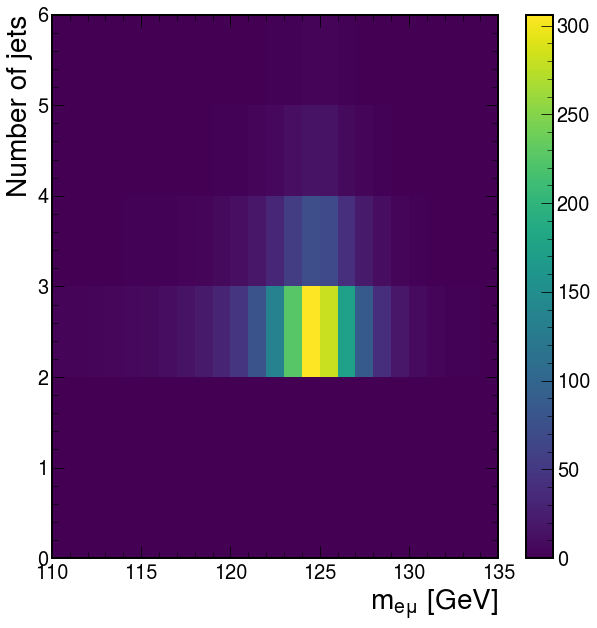

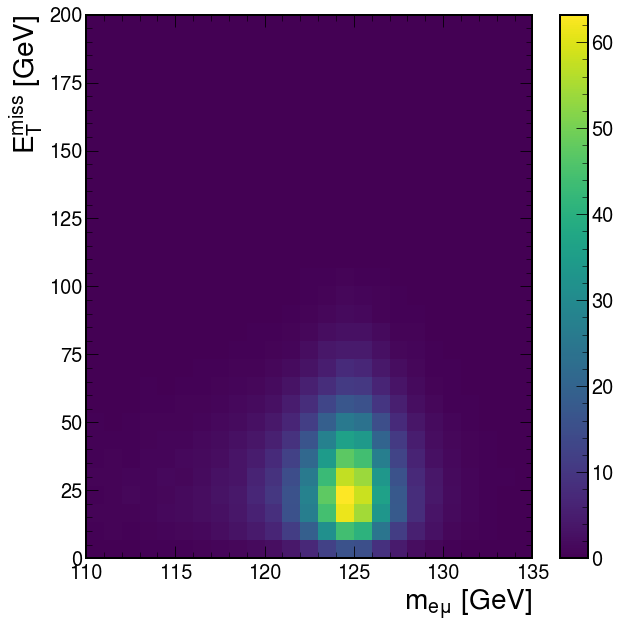

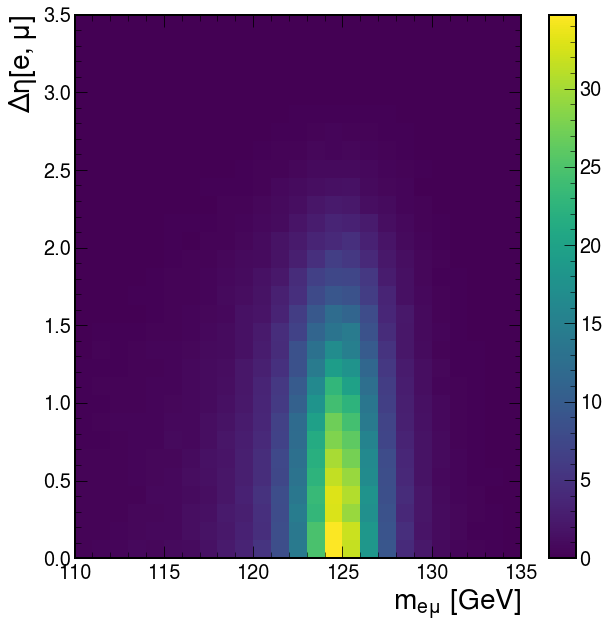

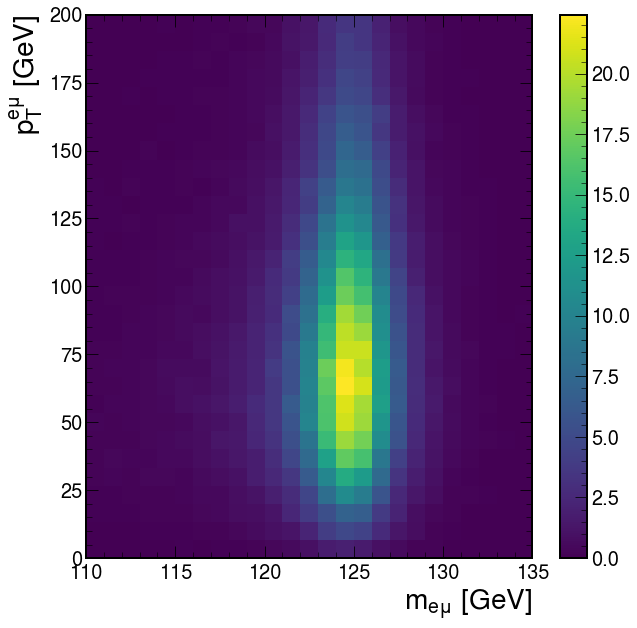

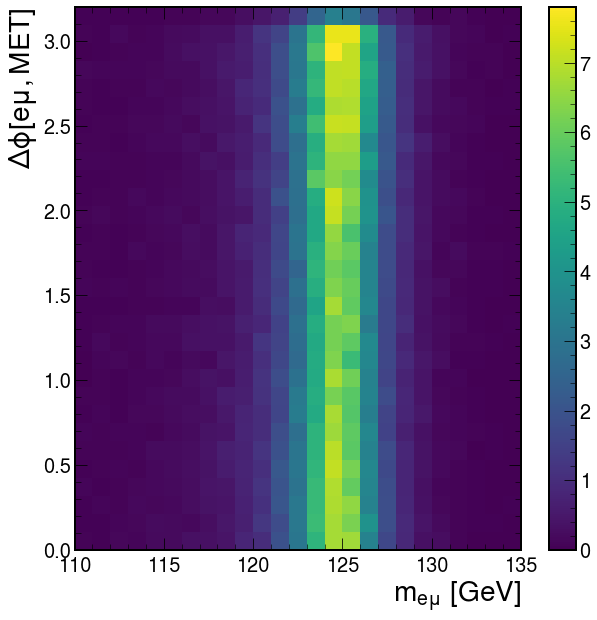

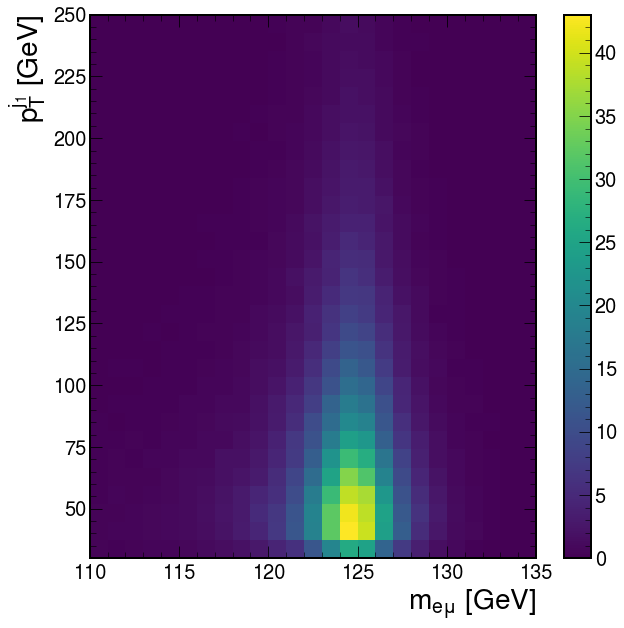

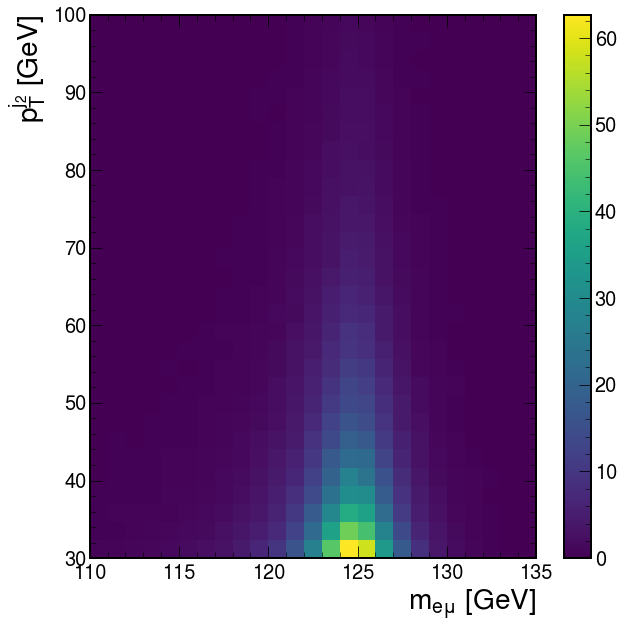

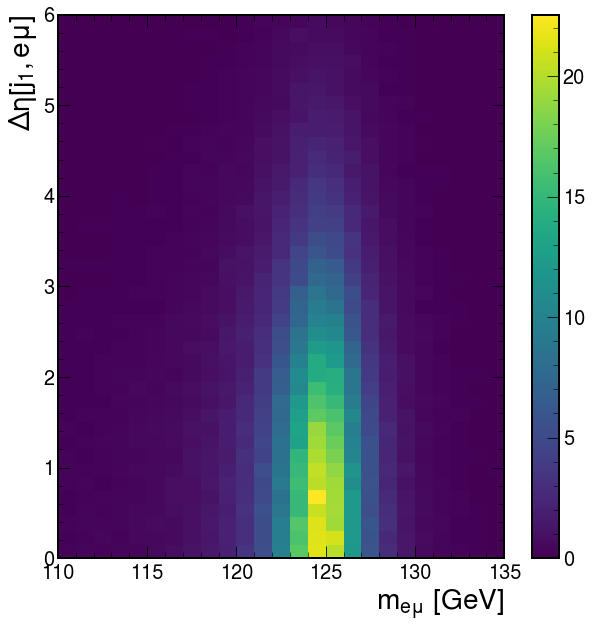

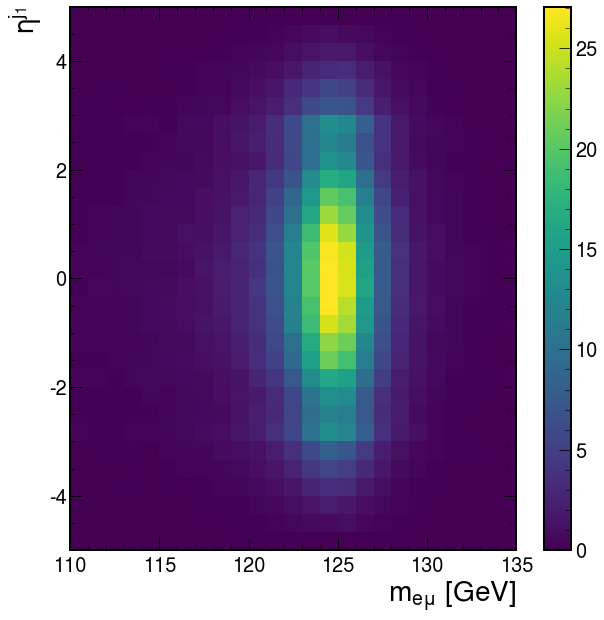

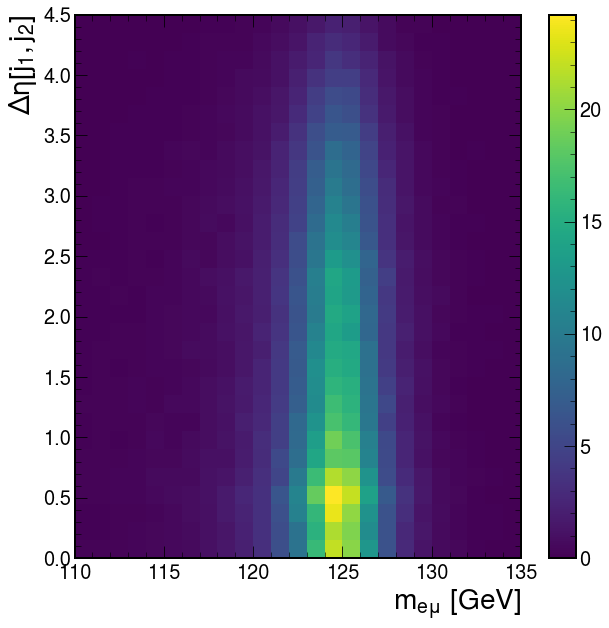

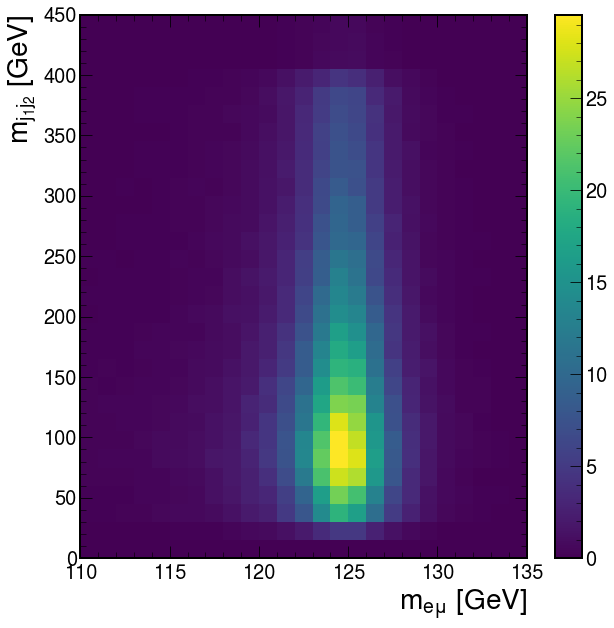

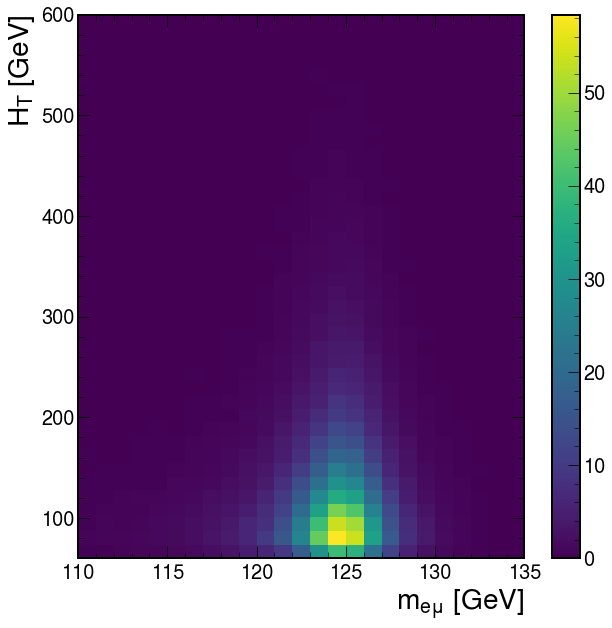

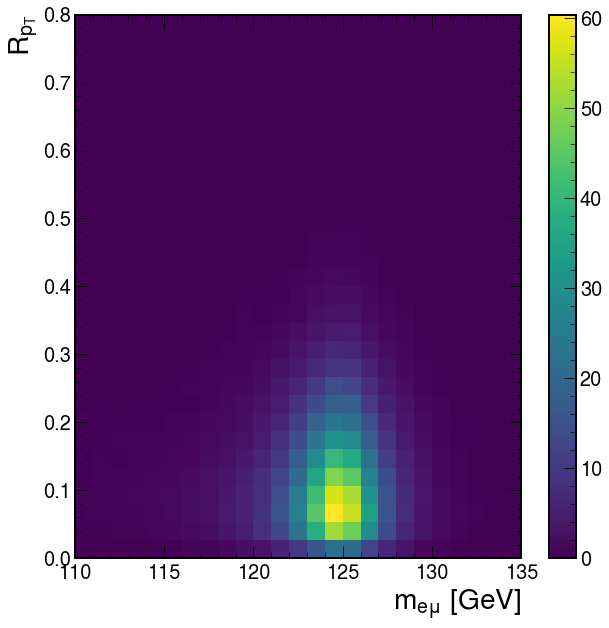

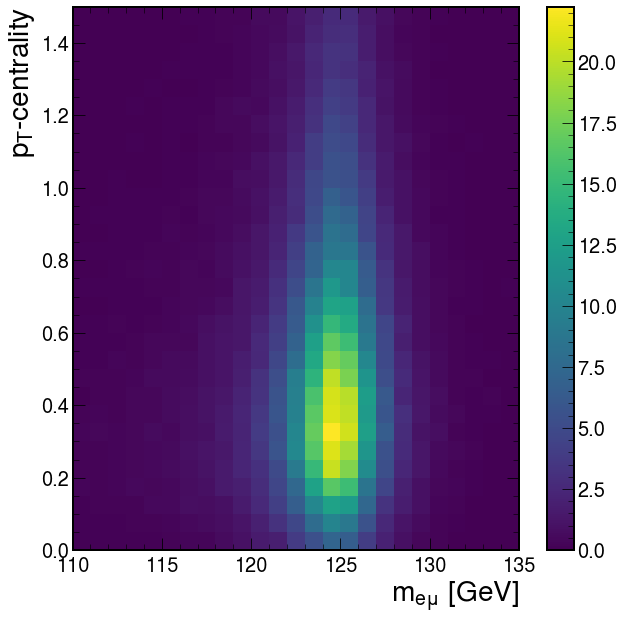

In [47]:
for feature_name in feature_names:
    h = hist.Hist("",
                    hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 25, 110, 135),
                    hist.Bin(feature_name, *features_map[feature_name])
                    )
    args = {'e_m_Mass':data_bkg['e_m_Mass'].to_numpy(), feature_name:data_bkg[feature_name].to_numpy(), 'weight':data_bkg['weight'].to_numpy() }
    h.fill(**args)
    hist.plot2d(h, xaxis='e_m_Mass')

In [ ]:
from coffea import hist
import mplhep
import matplotlib.pyplot as plt
%matplotlib inline

#Get the signal
data_bkg = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==0)]

#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW

for feature_name in feature_names:
    wq = DescrStatsW(data=data_bkg[feature_name], weights=data_bkg['weight'])
    h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 25, 110, 135), hist.Cat("sample", "sample"))
    quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)
    for i in range(len(quantiles)-1):
        #Fill in sliced invariant mass according to MVA quantiles
        quant25 = data_bkg[(data_bkg[feature_name]<quantiles[i+1])&(data_bkg[feature_name]>=quantiles[i])]
        label = f'{quantiles[i]:.2f} < {feature_names_tex_dict[feature_name]} < {quantiles[i+1]:.2f}'
        h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
        #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

    #h_quan.scale(scales, axis='sample')

    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 30,
        'axes.titlesize': 24,
        'axes.labelsize': 28,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.title_fontsize': 20
    })

    fig = plt.figure(
            figsize=(12,12),
          )

    ax = hist.plot1d(h_quan, density=True)
    #ax.set_ylim(0, 0.05)
    leg = ax.legend(fontsize='x-small', labelspacing=0.25, title=f"ggH\nCorrelation={corr(data_bkg[feature_name], data_bkg['e_m_Mass'], data_bkg['weight']):.3f}")
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0].split(' < ')[0])))
    plt.setp(leg.get_title(), multialignment='center')
#    plt.setp(leg.get_texts(), multialignment='center')
#     for t in leg.get_texts():
#         t.set_ha('right')

    lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
    #fig.savefig(f'plots/BDTValid/{catcatcat}_bkg.png')

/tmp/ipykernel_725109/3787273764.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bkg['mpt'] = data_bkg['mpt_Per_e_m_Mass']*data_bkg['e_m_Mass']


[100.5, 25.73, 44.39, 58.82, 75.6]


/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/mplhep/plot.py:44: RuntimeWarning: divide by zero encountered in true_divide
  binnorms /= np.outer(np.diff(bins), per_hist_norm).T
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/mplhep/plot.py:313: RuntimeWarning: invalid value encountered in multiply
  h *= density_arr
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/mplhep/plot.py:316: RuntimeWarning: invalid value encountered in multiply
  _yerr_lo[i] = _yerr_lo[i] * density_arr[i]
/afs/crc.nd.edu/user/k/kho2/miniconda3/envs/my-coffea-env/lib/python3.9/site-packages/mplhep/plot.py:317: RuntimeWarning: invalid value encountered in multiply
  _yerr_hi[i] = _yerr_hi[i] * density_

[2.0, 2.0, 3.0]
[0.07, 15.71, 24.19, 33.14, 45.4]
[0.0, 0.28, 0.58, 0.91, 1.34]
[0.07, 142.6, 47.81, 71.69, 98.43]
[-0.61, -1.92, -3.14, 0.63, 1.95]
[118.03, 30.06, 46.29, 60.64, 80.67]
[30.0, 33.09, 37.61, 44.8, 59.17]
[0.0, 0.56, 1.15, 1.83, 2.78]
[-0.49, -1.62, -4.7, 0.49, 1.62]
[0.0, 0.54, 1.13, 1.89, 2.78]
[119.41, 15.49, 175.14, 262.57, 77.92]
[101.95, 128.45, 176.76, 60.06, 82.58]
[0.0, 0.06, 0.09, 0.13, 0.2]
[-239.13, 0.23, 0.42, 0.64, 1.08]


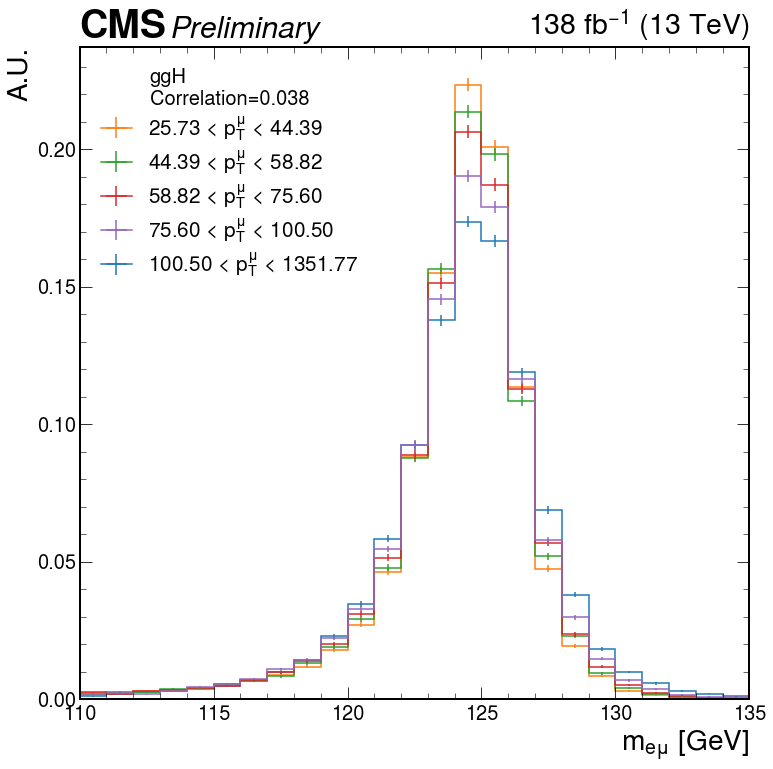

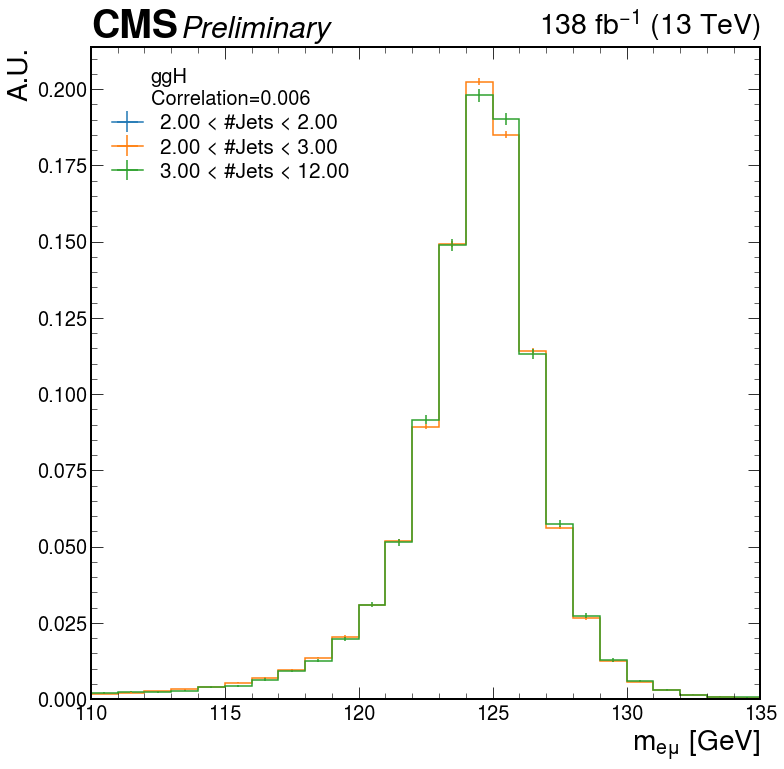

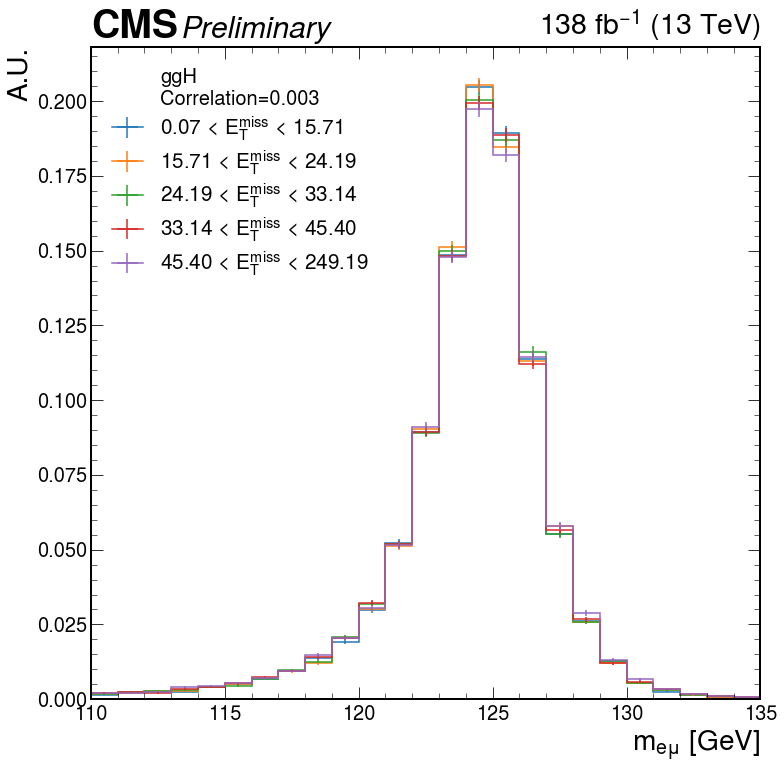

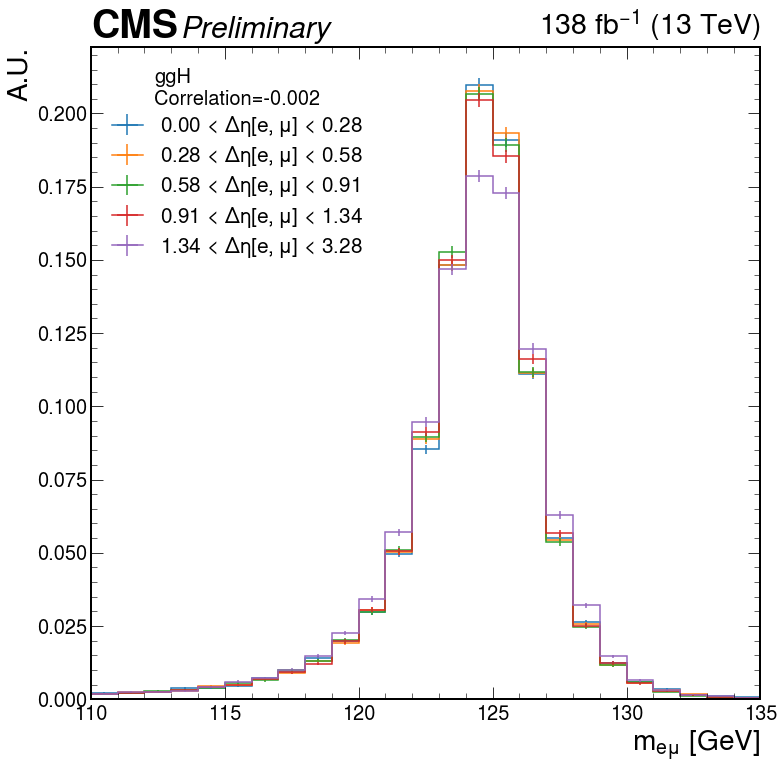

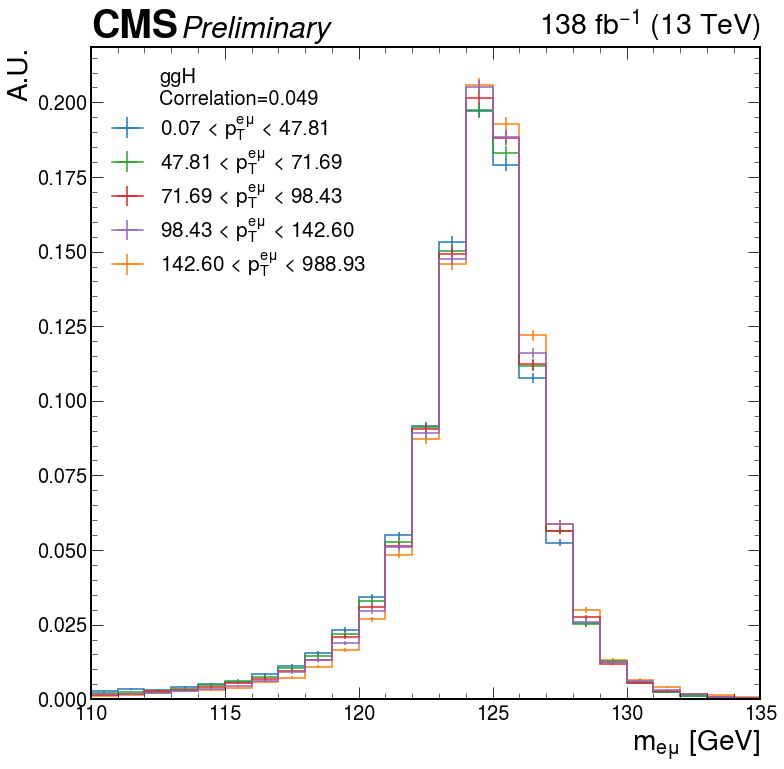

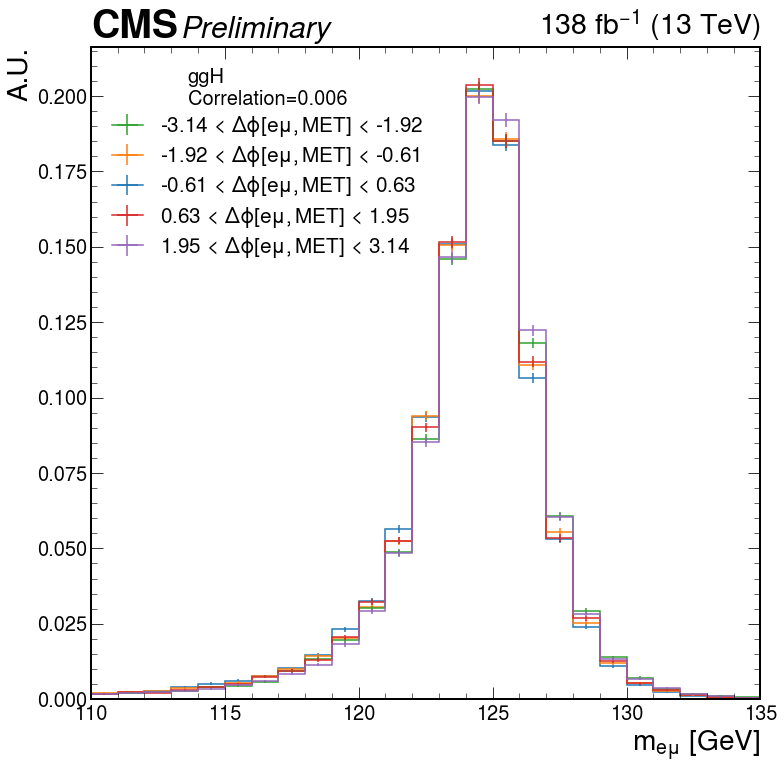

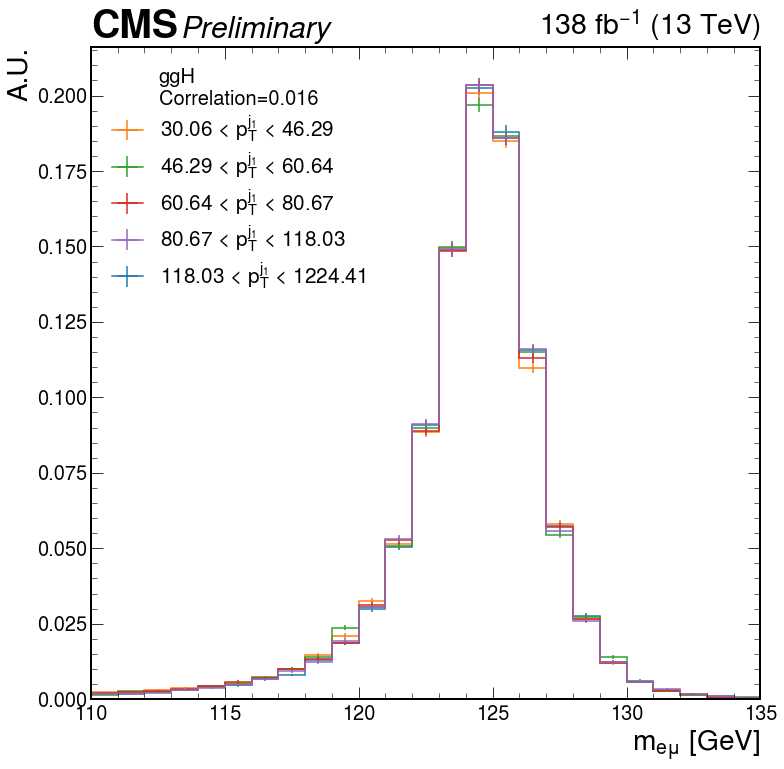

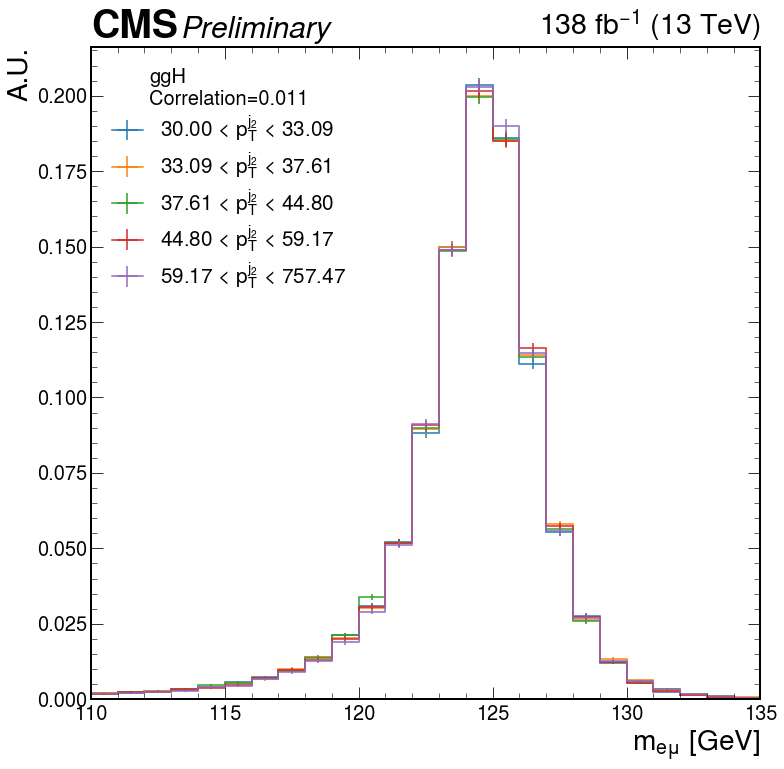

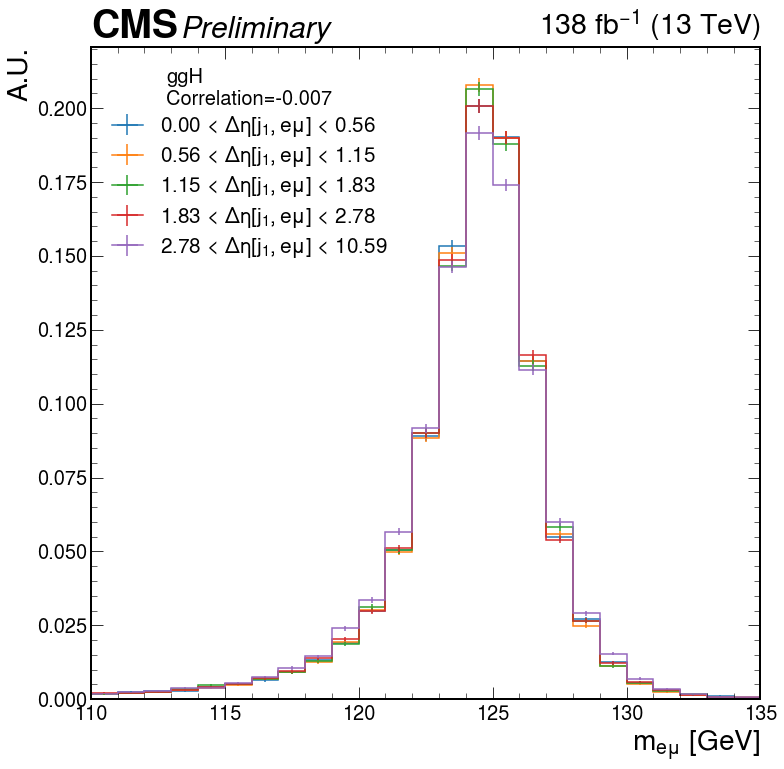

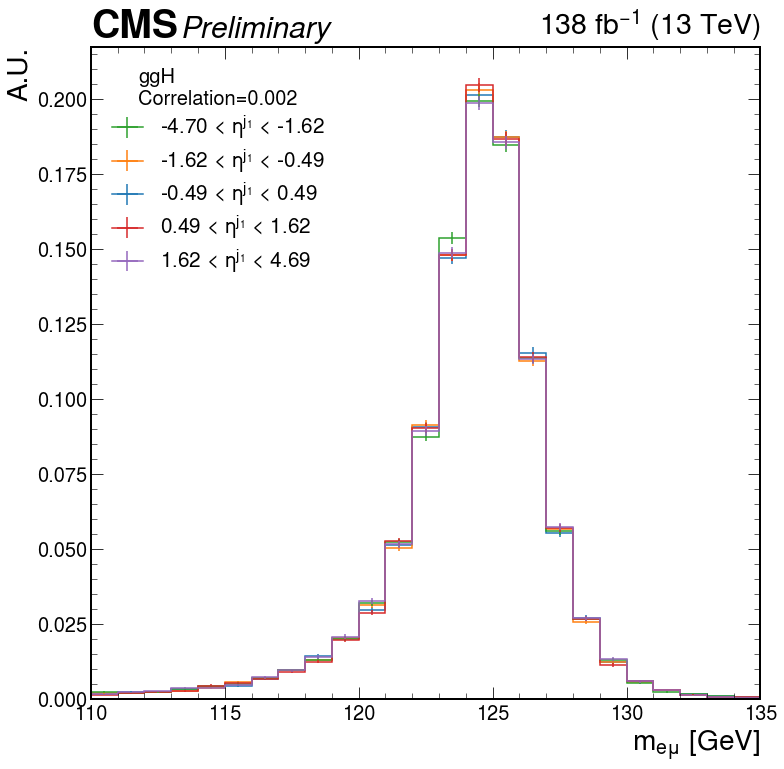

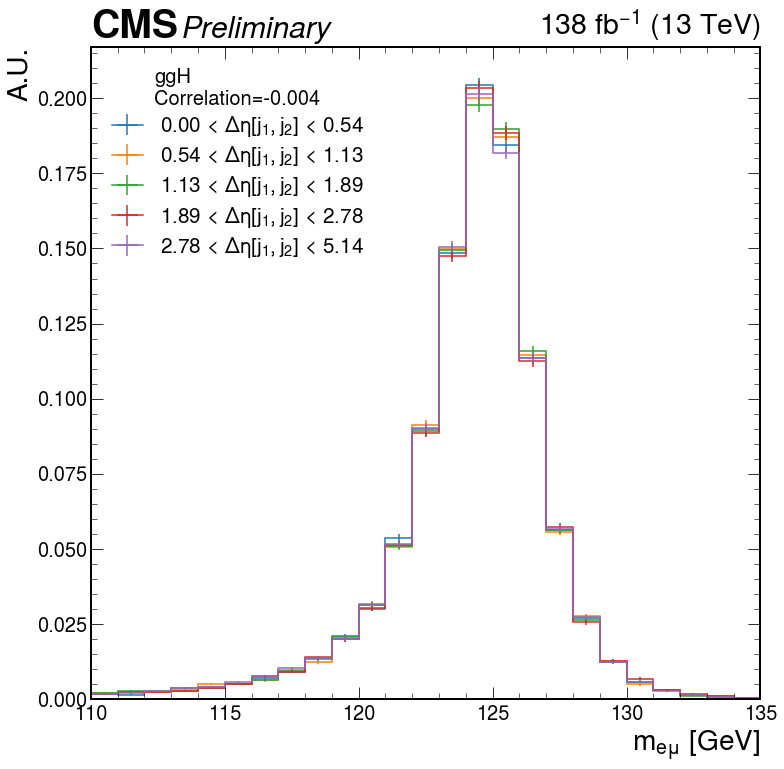

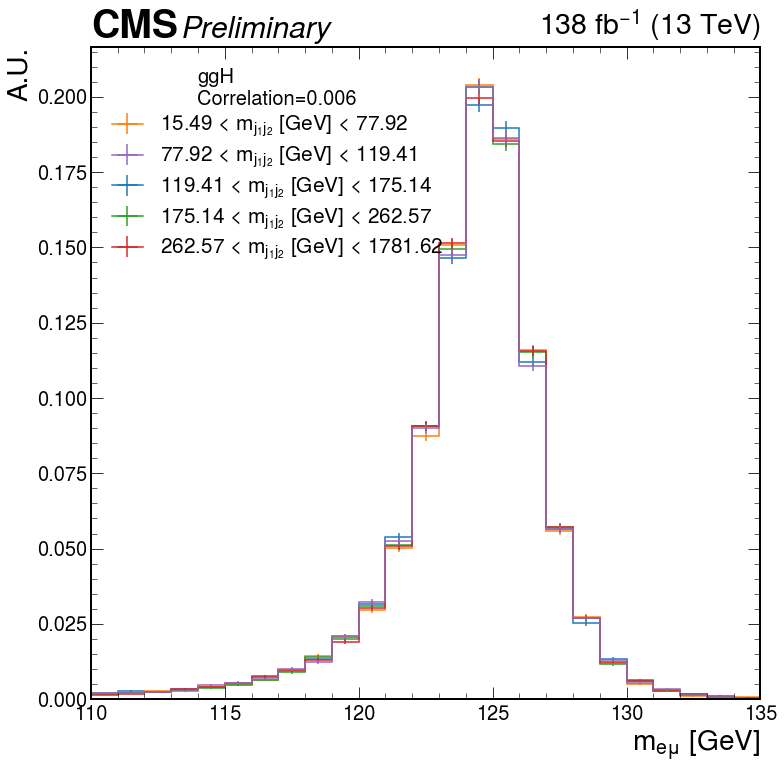

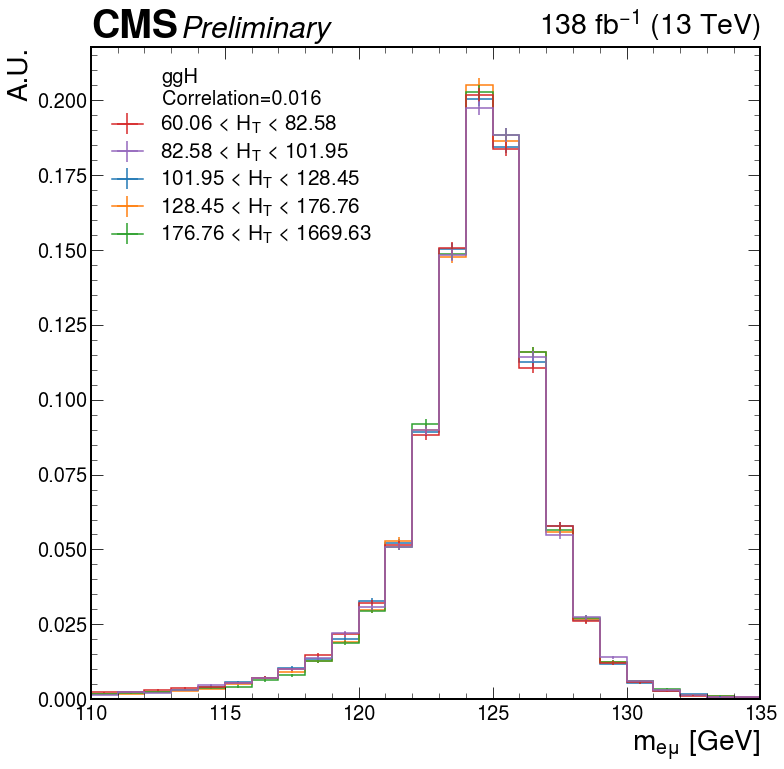

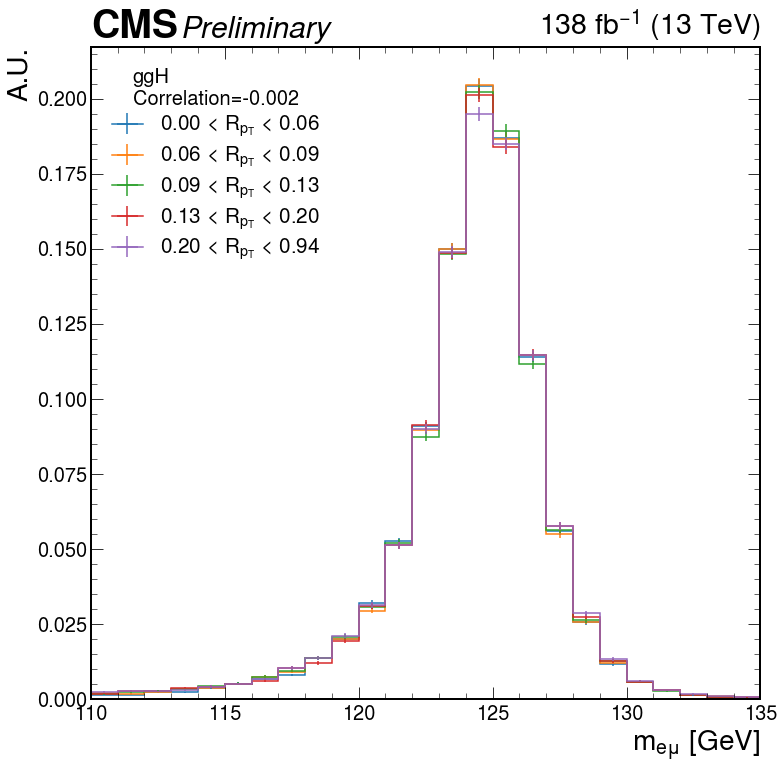

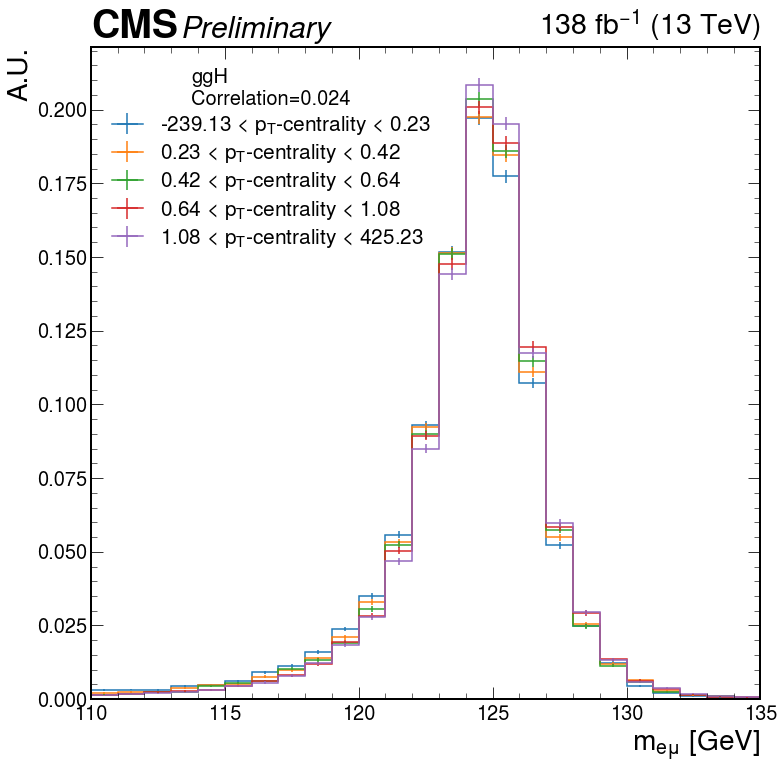

In [64]:
from coffea import hist
import mplhep
import matplotlib.pyplot as plt
%matplotlib inline

#Get the signal
data_bkg = data_clean[(data_clean['label']==1)&(data_clean['opp_charge']==1)&(data_clean['isVBFcat']==0)]
data_bkg['mpt'] = data_bkg['mpt_Per_e_m_Mass']*data_bkg['e_m_Mass']
#Get 20% quantiles of the background
from statsmodels.stats.weightstats import DescrStatsW

for feature_name in feature_names:
    wq = DescrStatsW(data=data_bkg[feature_name], weights=data_bkg['weight'])
    h_quan = hist.Hist('A.U.', hist.Bin('e_m_Mass', '$m_{e\mu}$ [GeV]', 25, 110, 135), hist.Cat("sample", "sample"))
    quantiles = wq.quantile(probs=np.array([0, 0.20, 0.40, 0.60, 0.80, 1]), return_pandas=False)
    for i in range(len(quantiles)-1):
        #Fill in sliced invariant mass according to MVA quantiles
        quant25 = data_bkg[(data_bkg[feature_name]<quantiles[i+1])&(data_bkg[feature_name]>=quantiles[i])]
        label = f'{quantiles[i]:.2f} < {feature_names_tex_dict[feature_name]} < {quantiles[i+1]:.2f}'
        h_quan.fill(e_m_Mass=quant25['e_m_Mass'].to_numpy(), sample=label, weight=quant25['weight'].to_numpy())
        #scales[label] = 1/np.sum(quant25['weight'].to_numpy())

    #h_quan.scale(scales, axis='sample')

    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 30,
        'axes.titlesize': 24,
        'axes.labelsize': 28,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'legend.title_fontsize': 20
    })

    fig = plt.figure(
            figsize=(12,12),
          )

    ax = hist.plot1d(h_quan, density=True)
    #ax.set_ylim(0, 0.05)
    leg = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    print([float(label.split(' < ')[0]) for label in labels])
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0].split(' < ')[0])))
    leg = ax.legend(handles, labels, fontsize='x-small', labelspacing=0.25, title=f"ggH\nCorrelation={corr(data_bkg[feature_name], data_bkg['e_m_Mass'], data_bkg['weight']):.3f}")
    plt.setp(leg.get_title(), multialignment='center')
#    plt.setp(leg.get_texts(), multialignment='center')
#     for t in leg.get_texts():
#         t.set_ha('right')

    lumi = mplhep.cms.label(ax=ax, lumi=138, label="Preliminary", data=1)
    #fig.savefig(f'plots/BDTValid/{catcatcat}_bkg.png')